### Dataset Dolar - Janela Somente da Cotação

,t,ano,mes,cotacao,ipca_acumulado,cpi,selic,divida_pp,fed_rate,cotacao_mean,cotacao_std
0,1,2000,1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.784000,0.000000
1,2,2000,2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.784000,0.000000
2,3,2000,3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.776000,0.011314
3,4,2000,4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.763833,0.022541
4,5,2000,5,1.8240,10.00,171.200,18.512727,51.27,6.27,1.770833,0.032842
...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024,7,5.6500,157.05,313.534,10.400000,77.44,5.33,5.343400,0.217223
295,296,2024,8,5.6103,157.03,314.121,10.400000,77.65,5.33,5.495600,0.219523
296,297,2024,9,5.4482,157.47,314.686,10.495238,77.44,5.13,5.617600,0.029437
297,298,2024,10,5.7867,158.03,315.454,10.650000,77.75,4.83,5.569500,0.106908


Melhores hiperparâmetros: OrderedDict({'C': 61.39704214749652, 'epsilon': 0.0001, 'gamma': 0.013796595812038823, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.20270011591244028
R² score: 0.43330466734615103


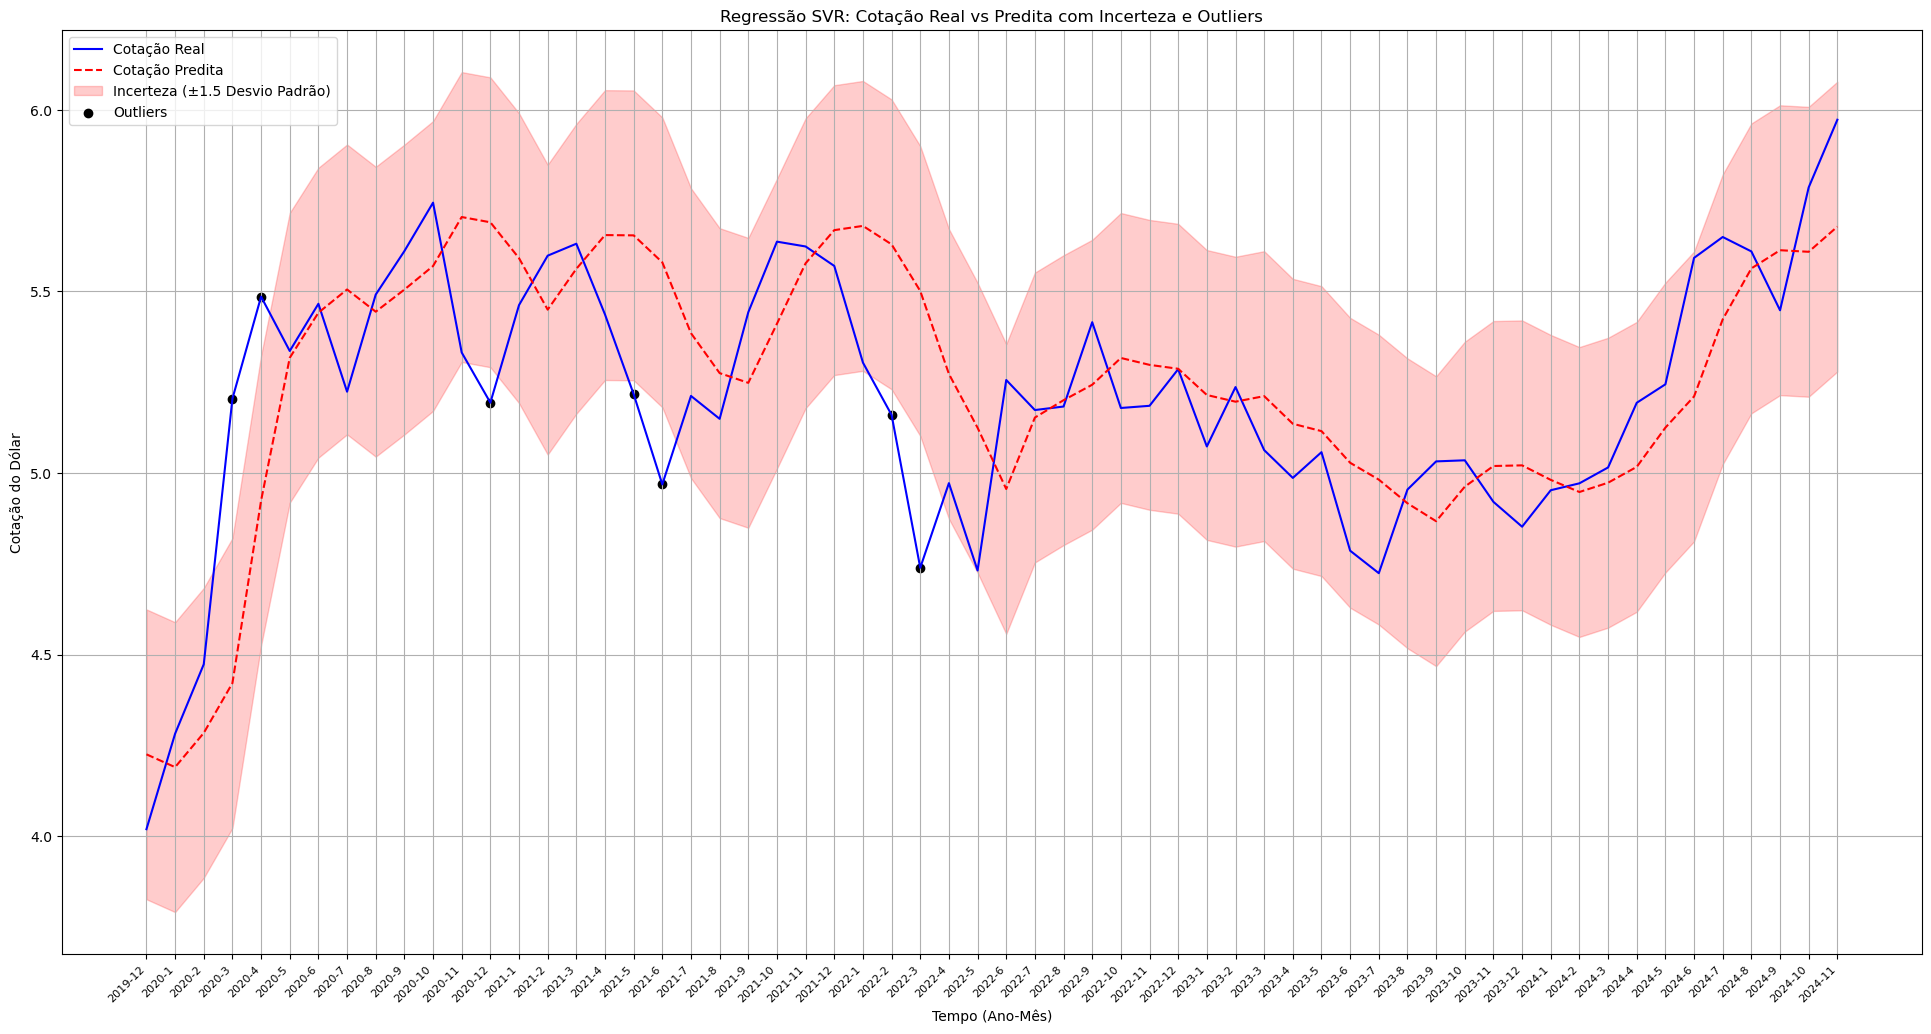

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
df['cotacao_mean'] = df['cotacao'].shift(1).rolling(window=3, min_periods=1).mean()
df.fillna(df['cotacao'].values[0], inplace=True)  # Lidar com NaNs no início

df['cotacao_std'] = df['cotacao'].shift(1).rolling(window=3, min_periods=1).std()

df.fillna(0, inplace=True)  # Lidar com NaNs no início

display(df)

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']


# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.80)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf', 'poly'] 
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=5)

# Otimização Bayesiana com TimeSeriesSplit e métrica R²
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações, 70
    cv=tscv,  # Mantém a sequência temporal
    scoring='neg_mean_absolute_error',  # Maximizar R²
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs = {'base_estimator': 'GP'}
)

# Treinar o modelo
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro)
residuos = y_test - y_pred

# Calcular o desvio padrão dos resíduos
std_dev = np.std(residuos)

mul_std = 1.5
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

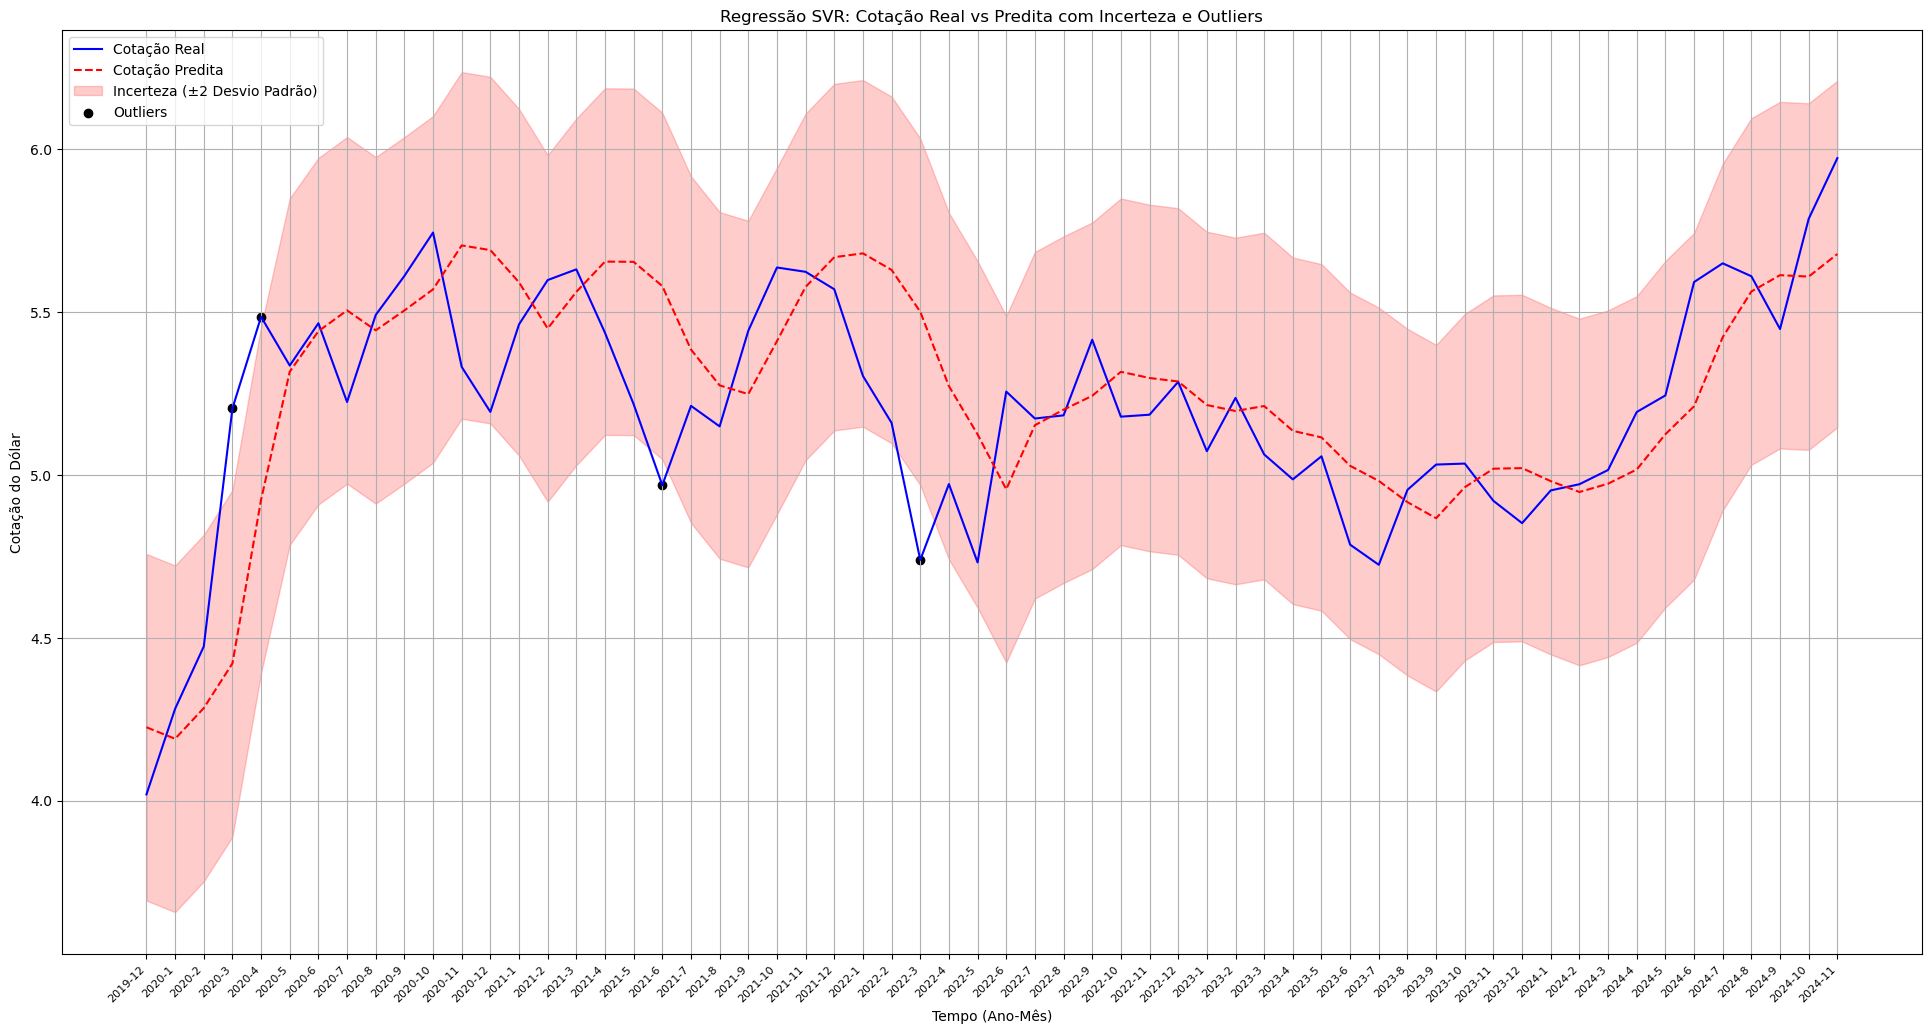

In [2]:
mul_std = 2
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

### Dataset Dolar - Janela com todos os atributos

,t,ano,mes,cotacao,ipca_acumulado,cpi,selic,divida_pp,fed_rate,cotacao_mean,...,ipca_acumulado_mean,ipca_acumulado_std,cpi_mean,cpi_std,selic_mean,selic_std,divida_pp_mean,divida_pp_std,fed_rate_mean,fed_rate_std
0,1,2000,1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.784000,...,9.220000,0.000000,169.300000,0.000000,18.937619,0.000000,51.270000,0.000000,5.450000,0.000000
1,2,2000,2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.784000,...,9.220000,0.000000,169.300000,0.000000,18.937619,0.000000,51.270000,0.000000,5.450000,0.000000
2,3,2000,3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.776000,...,9.285000,0.091924,169.650000,0.494975,18.903571,0.048151,51.270000,0.000000,5.590000,0.197990
3,4,2000,4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.763833,...,9.380000,0.176918,170.100000,0.854400,18.884603,0.047314,51.270000,0.000000,5.676667,0.205264
4,5,2000,5,1.8240,10.00,171.200,18.512727,51.27,6.27,1.770833,...,9.636667,0.325167,170.633333,0.550757,18.778204,0.138847,51.270000,0.000000,5.866667,0.145717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024,7,5.6500,157.05,313.534,10.400000,77.44,5.33,5.343400,...,156.376667,0.342685,313.160333,0.096837,10.503175,0.130591,75.973333,0.807486,5.330000,0.000000
295,296,2024,8,5.6103,157.03,314.121,10.400000,77.65,5.33,5.495600,...,156.726667,0.299054,313.269333,0.245521,10.419841,0.034366,76.700000,0.825288,5.330000,0.000000
296,297,2024,9,5.4482,157.47,314.686,10.495238,77.44,5.13,5.617600,...,156.916667,0.213854,313.568000,0.536808,10.400000,0.000000,77.313333,0.414769,5.330000,0.000000
297,298,2024,10,5.7867,158.03,315.454,10.650000,77.75,4.83,5.569500,...,157.183333,0.248462,314.113667,0.576035,10.431746,0.054986,77.510000,0.121244,5.263333,0.115470


Melhores hiperparâmetros: OrderedDict({'C': 157.02770485352042, 'epsilon': 0.0001, 'gamma': 0.010274840196611346, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.21011531019073046
R² score: 0.40929586539924145


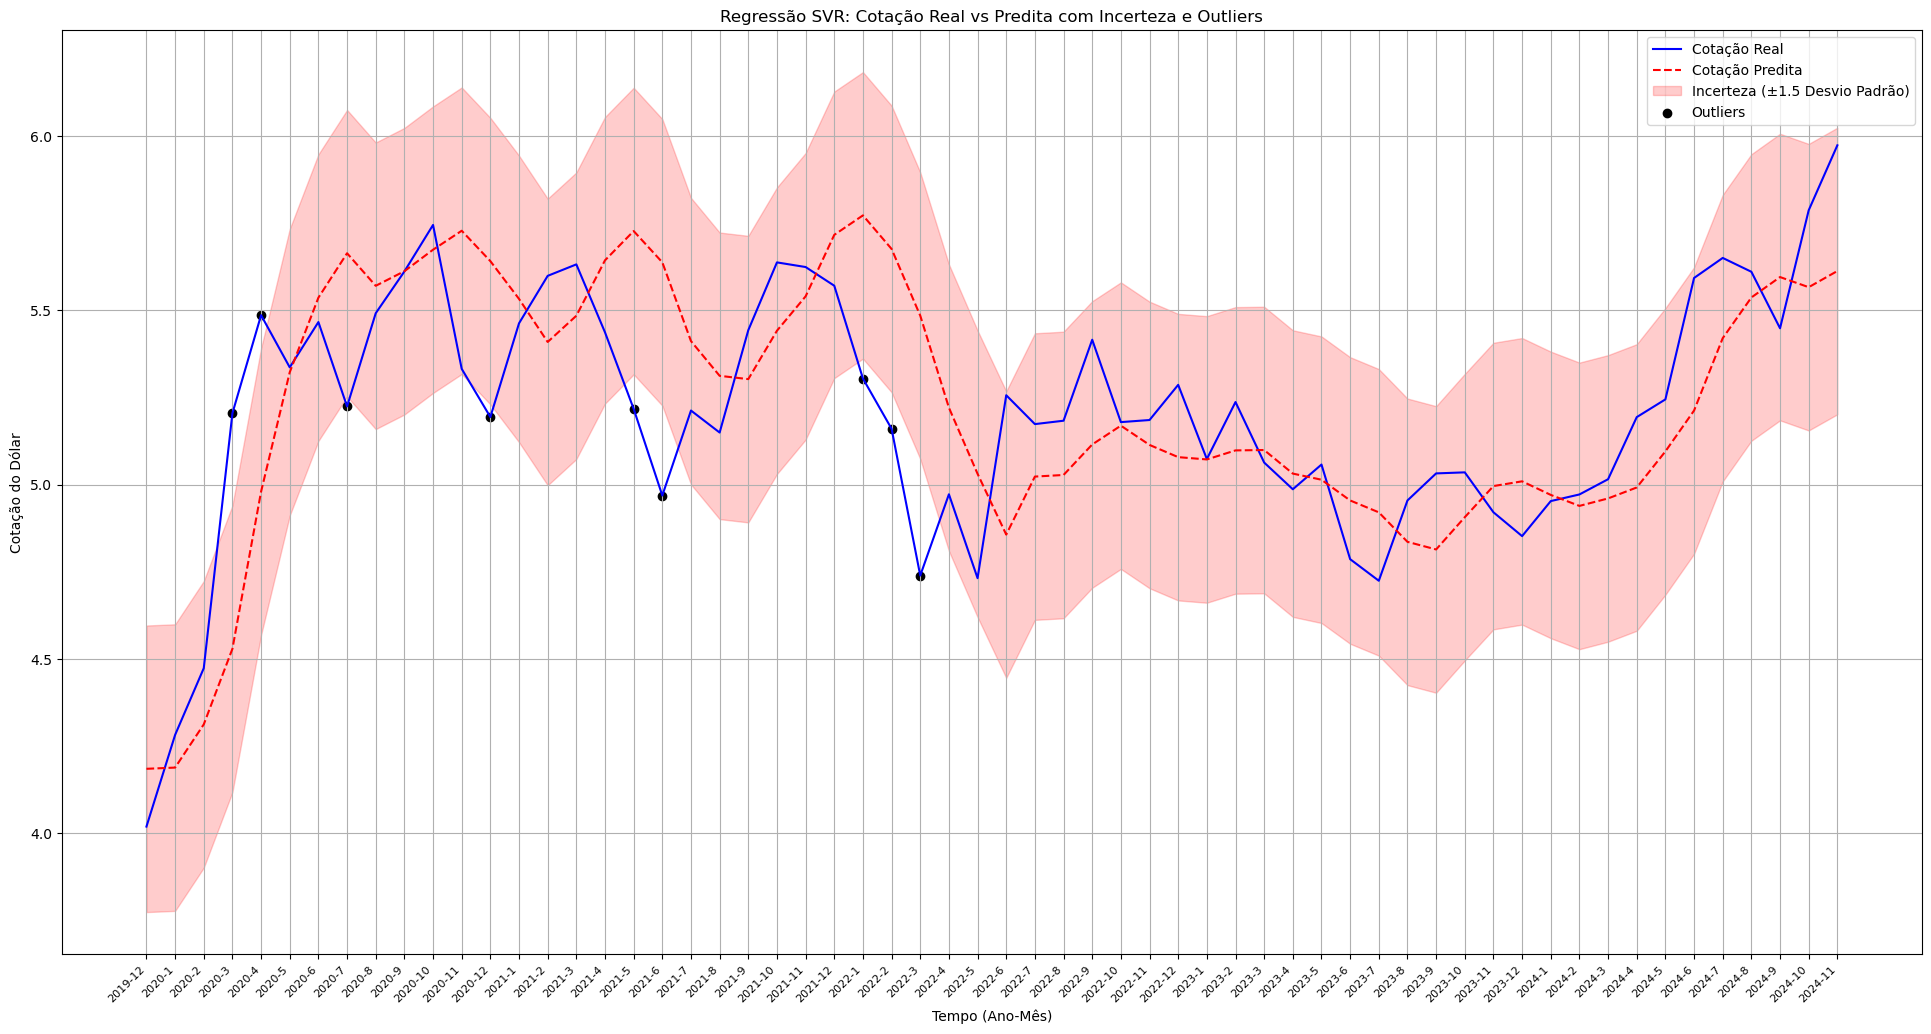

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)
df = df[['t', 'ano', 'mes', 'cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']]
# Criar novas features (médias móveis e desvio padrão)
for column in ['cotacao', 'ipca_acumulado', 'cpi', 'selic',
       'divida_pp', 'fed_rate']:
    mean_name = column + '_mean'
    std_name = column + '_std'
    df[mean_name] = df[column].shift(1).rolling(window=3, min_periods=1).mean()
    df.fillna(df[column].values[0], inplace=True)  # Lidar com NaNs no início

    
    df[std_name] = df[column].shift(1).rolling(window=3, min_periods=1).std()
    df.fillna(0, inplace=True)  # Lidar com NaNs no início
    
    

display(df)

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']


# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.80)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf', 'poly'] 
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=5)

# Otimização Bayesiana com TimeSeriesSplit e métrica R²
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações, 70
    cv=tscv,  # Mantém a sequência temporal
    scoring='neg_mean_absolute_error',  # Maximizar R²
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro)
residuos = y_test - y_pred

# Calcular o desvio padrão dos resíduos
std_dev = np.std(residuos)
mul_std = 1.5
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

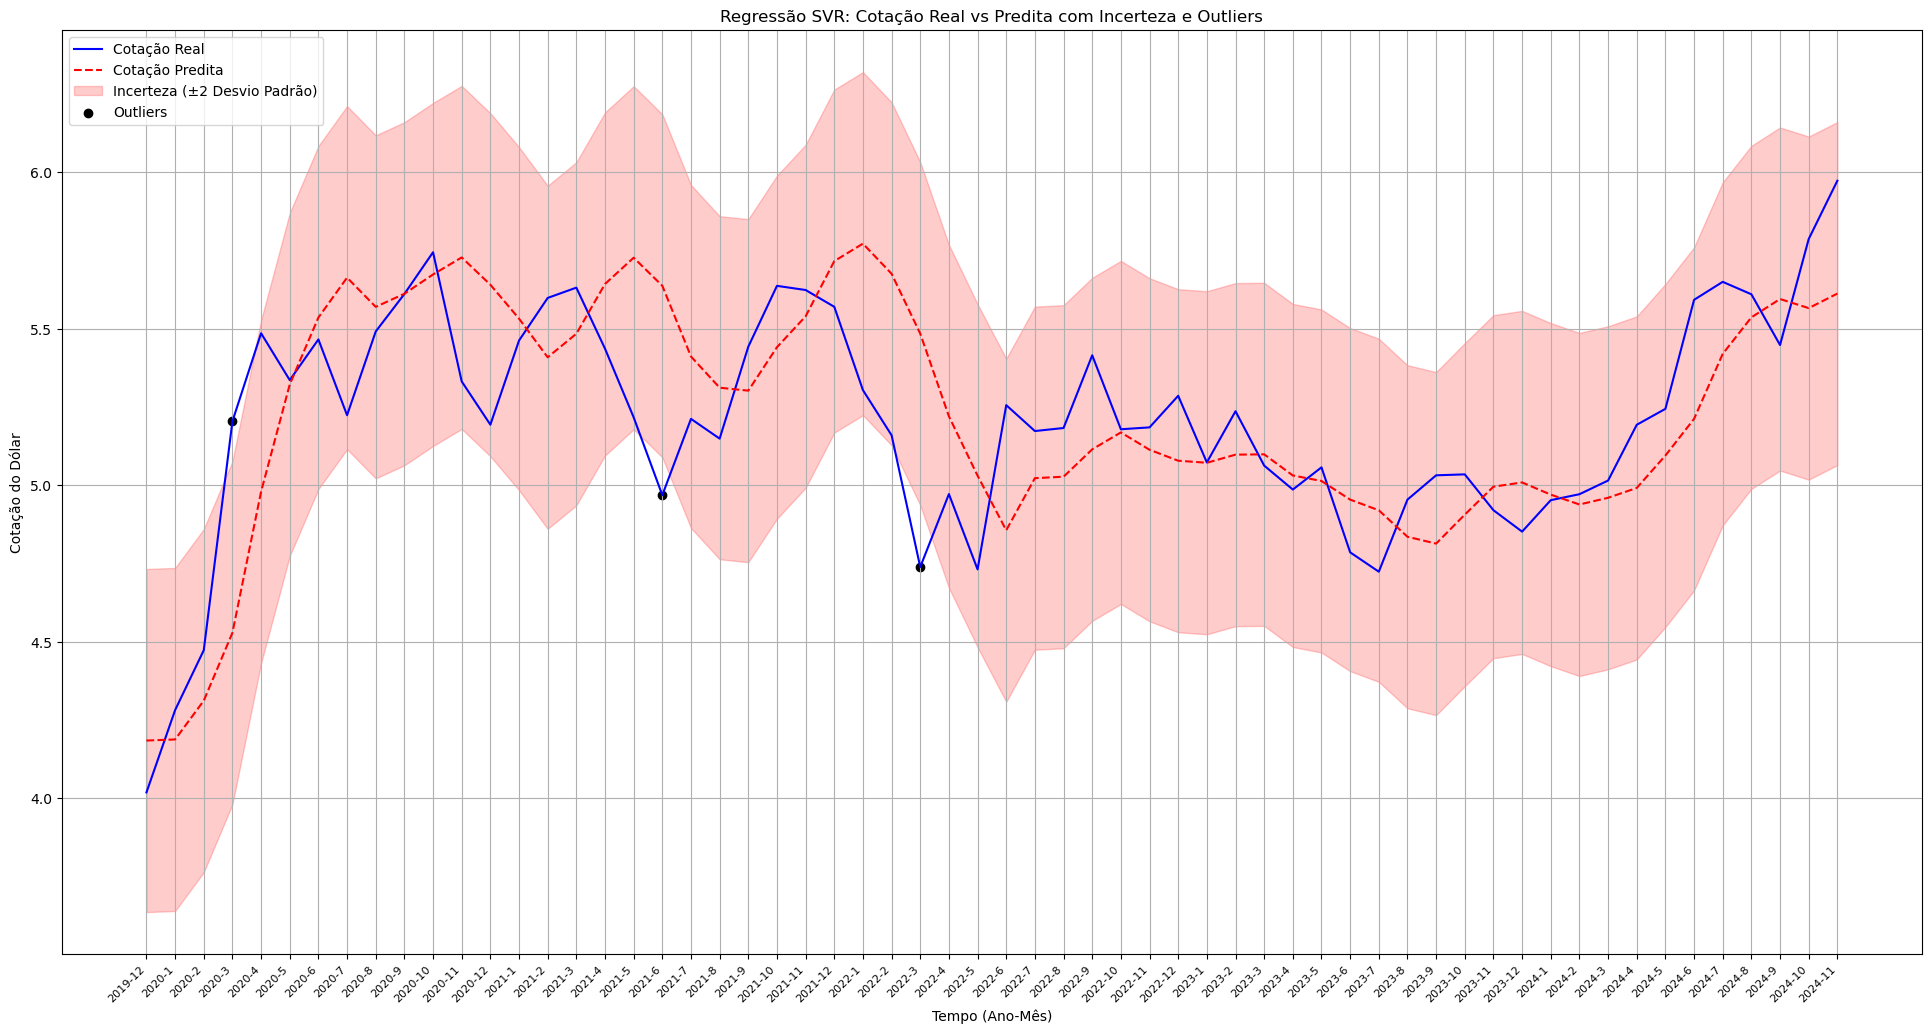

In [4]:
mul_std = 2
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

### Dataset Dolar - janela 6 meses

,t,ano,mes,cotacao,ipca_acumulado,cpi,selic,divida_pp,fed_rate,cotacao_1,...,cpi_4,selic_4,divida_pp_4,fed_rate_4,cotacao_5,ipca_acumulado_5,cpi_5,selic_5,divida_pp_5,fed_rate_5
0,1,2000,1,1.7840,9.22,169.300,18.937619,51.27,5.45,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
1,2,2000,2,1.7680,9.35,170.000,18.869524,51.27,5.73,1.7840,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
2,3,2000,3,1.7395,9.57,171.000,18.846667,51.27,5.85,1.7680,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
3,4,2000,4,1.8050,9.99,170.900,18.618421,51.27,6.02,1.7395,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
4,5,2000,5,1.8240,10.00,171.200,18.512727,51.27,6.27,1.8050,...,169.300,18.937619,51.27,5.45,1.7840,9.22,169.300,18.937619,51.27,5.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024,7,5.6500,157.05,313.534,10.400000,77.44,5.33,5.5925,...,312.230,11.000000,75.09,5.33,4.9716,155.46,311.054,11.150000,74.85,5.33
295,296,2024,8,5.6103,157.03,314.121,10.400000,77.65,5.33,5.6500,...,313.207,10.650000,75.26,5.33,5.0153,155.62,312.230,11.000000,75.09,5.33
296,297,2024,9,5.4482,157.47,314.686,10.495238,77.44,5.13,5.6103,...,313.225,10.459524,75.81,5.33,5.1934,156.00,313.207,10.650000,75.26,5.33
297,298,2024,10,5.7867,158.03,315.454,10.650000,77.75,4.83,5.4482,...,313.049,10.400000,76.85,5.33,5.2443,156.46,313.225,10.459524,75.81,5.33


Melhores hiperparâmetros: OrderedDict({'C': 67.1622960323484, 'epsilon': 0.0004893092827716302, 'gamma': 0.015370658218145738, 'kernel': 'rbf'})
Erro Médio Absoluto no Teste: 0.26688154561575916
R² score: 0.11039089393710844


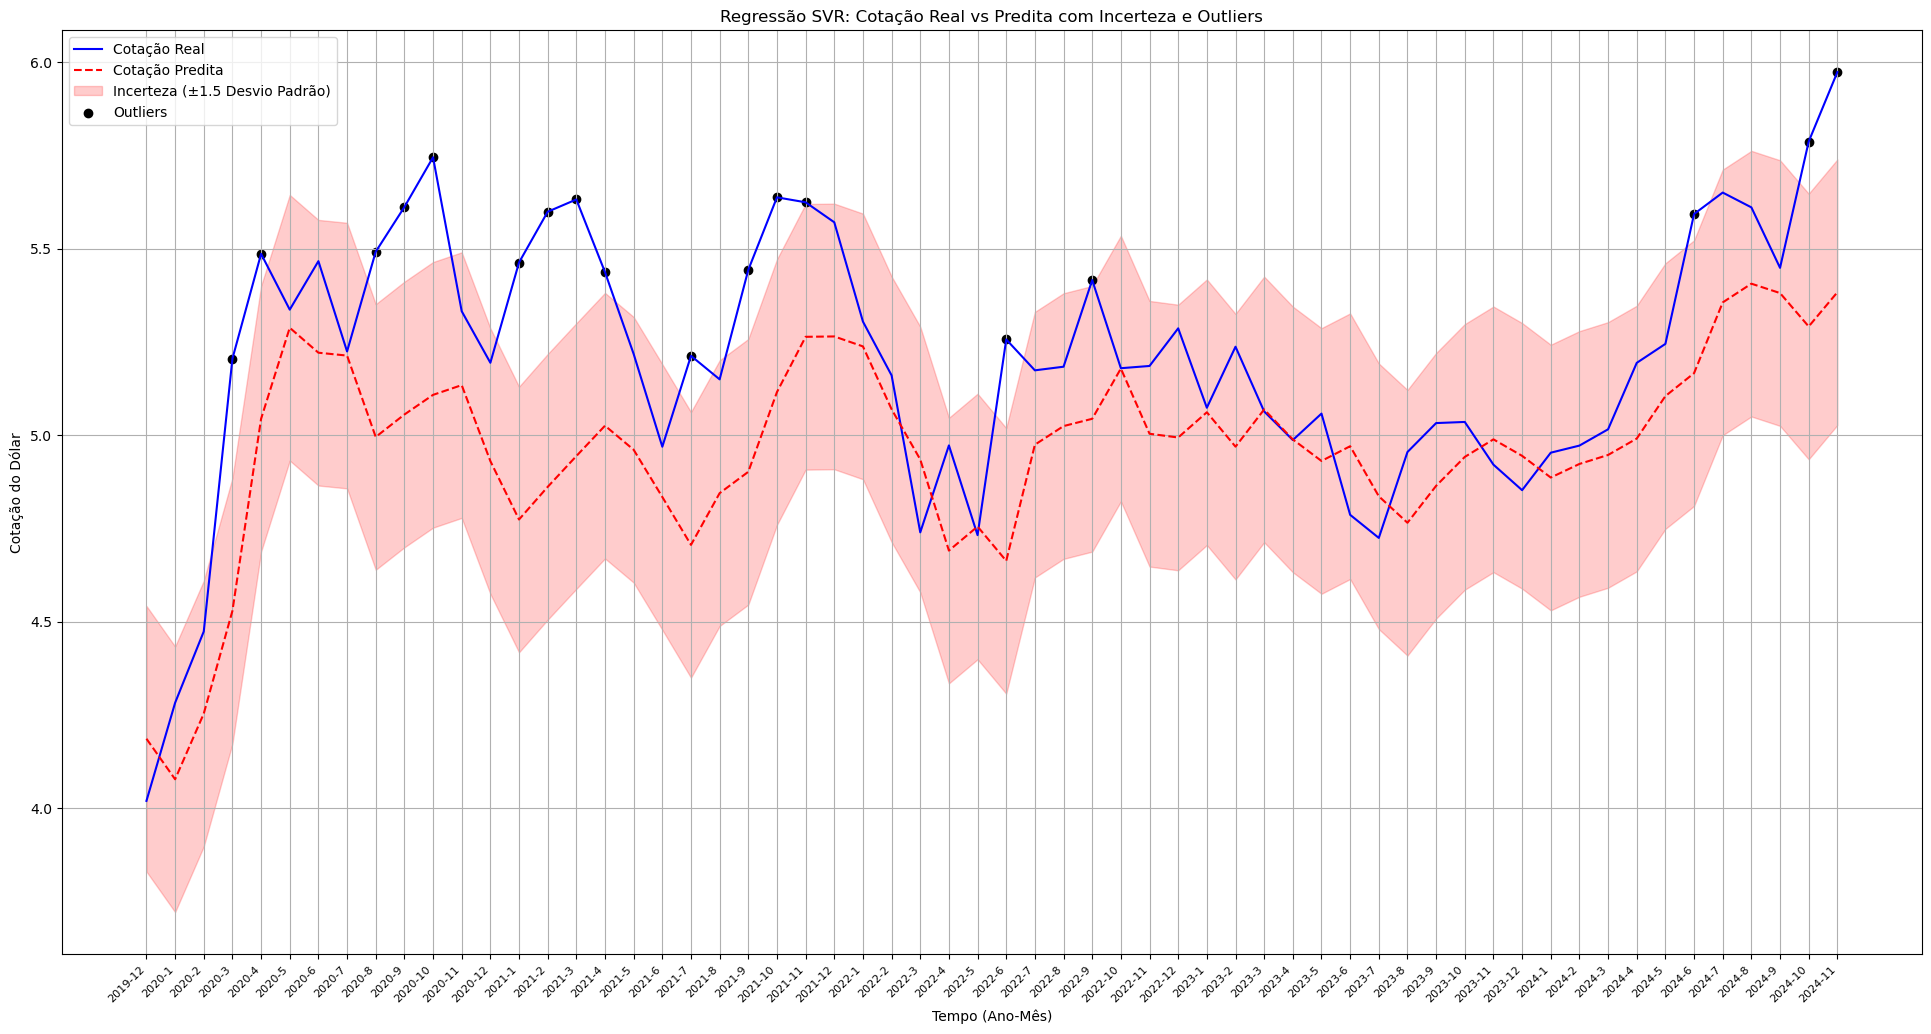

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar os dados
file_path = "Dataset_Dolar.csv"
df = pd.read_csv(file_path)

display(df)

# Definir variáveis preditoras e alvo
X = df.drop(columns=['cotacao','t', 'ano', 'mes'])  # Remover colunas irrelevantes
y = df['cotacao']


# Separar treino e teste preservando a ordem temporal (80% treino, 20% teste)
train_size = int(len(df) * 0.80)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Normalizar os dados com MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir o modelo SVR
svr = SVR()

# Definir os hiperparâmetros a serem otimizados
param_grid = {
    'C': (0.1, 1000.0, 'log-uniform'),
    'epsilon': (0.0001, 1.0, 'log-uniform'),
    'gamma': (1e-5, 1.0, 'log-uniform'),
    'kernel': ['rbf', 'poly'] 
}

# Validação cruzada preservando ordem temporal
tscv = TimeSeriesSplit(n_splits=3)

# Otimização Bayesiana com TimeSeriesSplit e métrica R²
bayes_search = BayesSearchCV(
    svr,
    param_grid,
    n_iter=40,  # Número de avaliações, 70
    cv=tscv,  # Mantém a sequência temporal
    scoring='neg_mean_absolute_error',  # Maximizar R²
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo
bayes_search.fit(X_train_scaled, y_train)

# Exibir melhores hiperparâmetros
print("Melhores hiperparâmetros:", bayes_search.best_params_)

# Avaliar no conjunto de teste
best_svr = bayes_search.best_estimator_
y_pred = best_svr.predict(X_test_scaled)

# Calcular erro médio absoluto e R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Médio Absoluto no Teste:", mae)
print("R² score:", r2)

# Calcular os resíduos (erro)
residuos = y_test - y_pred

# Calcular o desvio padrão dos resíduos
std_dev = np.std(residuos)
mul_std = 1.5
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()

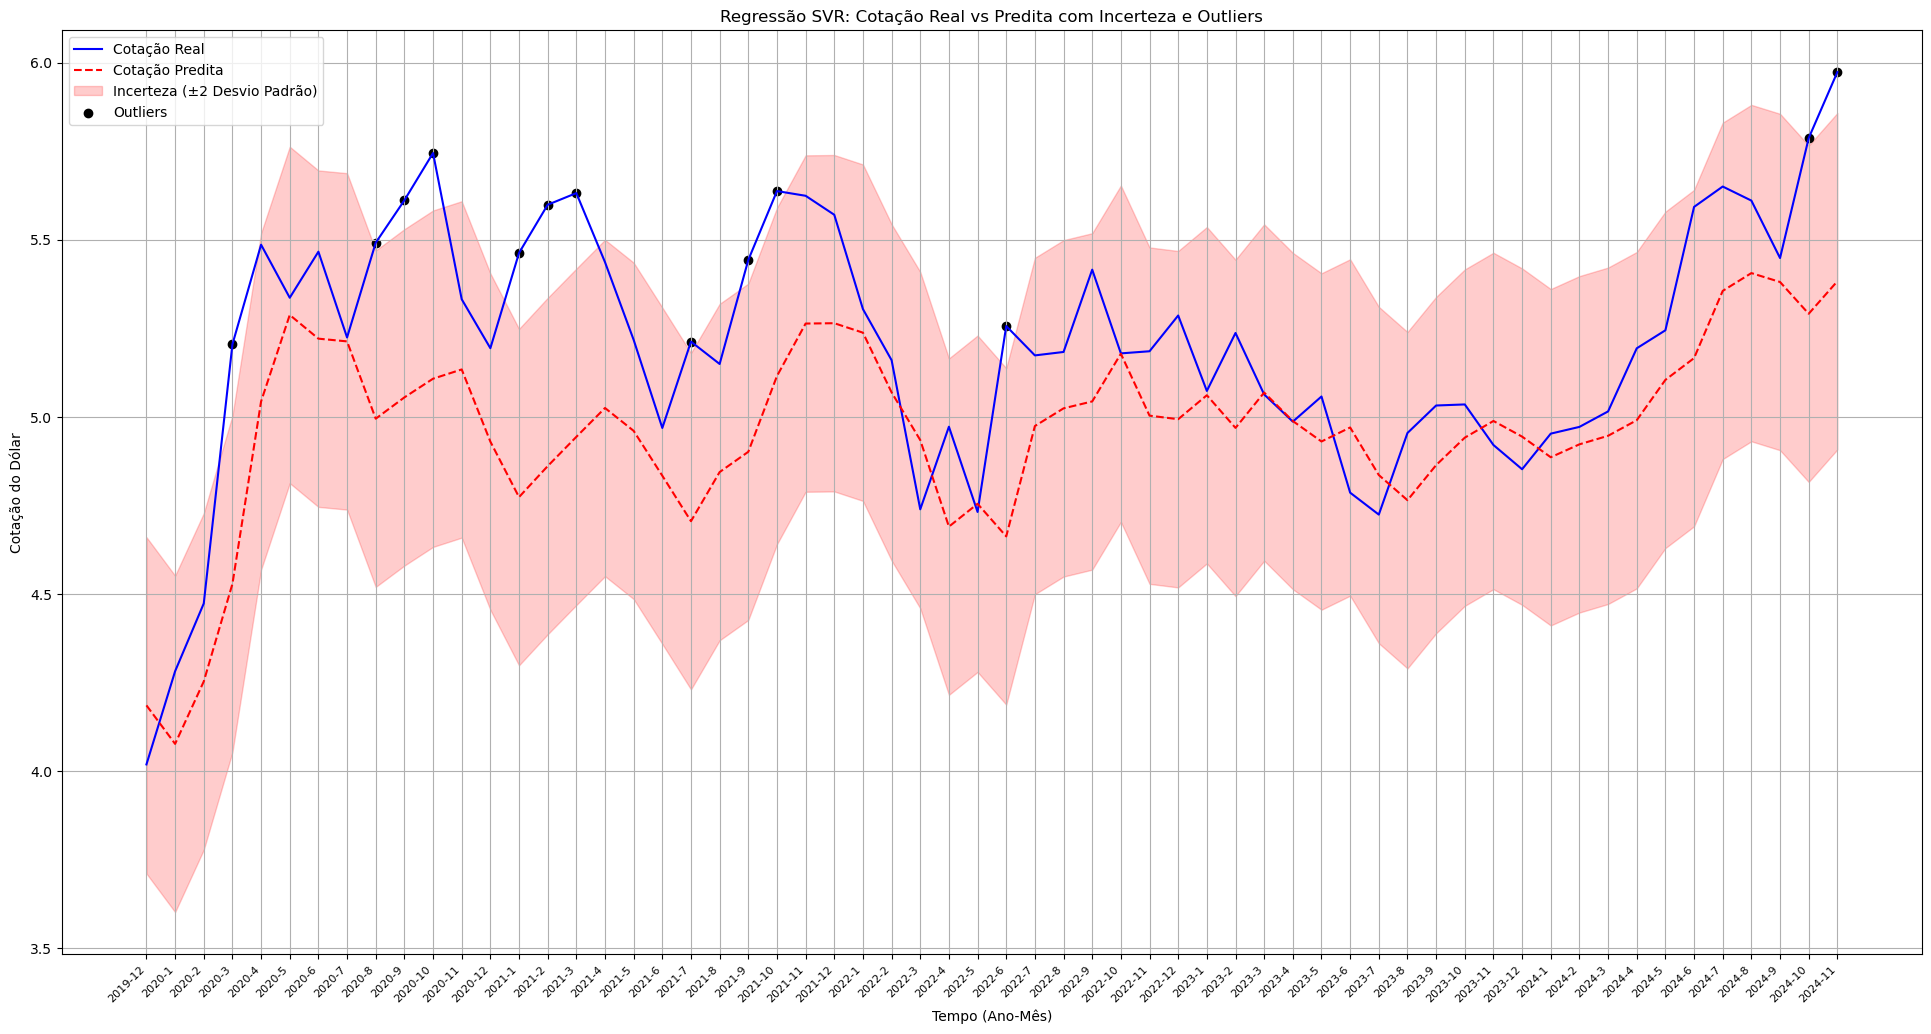

In [6]:
mul_std = 2
# Identificar pontos que estão fora da faixa de incerteza
lower_bound = y_pred - mul_std * std_dev
upper_bound = y_pred + mul_std * std_dev
outliers_mask = (y_test.values < lower_bound) | (y_test.values > upper_bound)

# Criar rótulos do eixo X (ano-mês) para o conjunto de teste
x_labels = df.iloc[train_size:][['ano', 'mes']].astype(str).agg('-'.join, axis=1).values

# Criar gráfico de predição vs. real
plt.figure(figsize=(24, 12))
plt.plot(x_labels, y_test.values, label="Cotação Real", color="blue")
plt.plot(x_labels, y_pred, label="Cotação Predita", color="red", linestyle="dashed")

# Adicionar faixa de incerteza
plt.fill_between(x_labels, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label=f"Incerteza (±{mul_std} Desvio Padrão)")

# Plotar os outliers como pontos destacados
plt.scatter(np.array(x_labels)[outliers_mask], y_test.values[outliers_mask], 
            color='black', marker='o', label="Outliers")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Cotação do Dólar")
plt.title("Regressão SVR: Cotação Real vs Predita com Incerteza e Outliers")
plt.legend()
plt.grid()
plt.show()